In [160]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [161]:
#openai's example
import re

# Example usage with capturing groups in alternation:
input_string = "The color of the car is either blue."
match = re.search(r'The color of the car is either (red|blue)\.', input_string)

if match:
    color = match.group(1)
    print("Car color:", color)
else:
    print("No match found.")

Car color: blue


In [162]:
relitive_path = "data\\"
file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
shots= ["8","13","14","37","39"]

filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", file_name))]
shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*Ch1.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]

shot_no

[13, 14, 8]

In [163]:
######## FUNCTIONS #########

def read_data(shot, silent= False):
    ###FIND MATCHING FILE NAMES
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    kirills_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT"+ str(shot) + "[^0-9]*[0-9]{3}[^0-9].*.csv", file_name))]
    phils_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*{:d}[^0-9]*\.csv".format(shot) , file_name))]
    xray_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT{:d}.tif".format(shot) , file_name))]
    filtered_file_names = kirills_file_names + phils_file_names + xray_file_names
    ###PRINT FILE INFO
    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]
    ###PUT OSCILLOSCOPE FILES INTO DICTIONARY
    dictionary = {}
    for phils_file_name in phils_file_names: # should only be 1 file
        for n, column in enumerate(["time","bdot","tof","diode"]): # some data files have Ch4 but it's just noise.
            dictionary[column] = np.genfromtxt(relitive_path+phils_file_name, delimiter=',', skip_header =18, usecols=n)
    ###PUT THZ FILES INTO DICTIONARY
    for kirill_file_name in kirills_file_names: # should only be 2 files
        for Ch in ["Ch1","Ch2","Ch3","Ch4"]:
            if Ch in kirill_file_name : channel = Ch # Python has got some weird ways of writing if statements.
        dictionary["pyro_time"], dictionary[channel] = np.genfromtxt(relitive_path+kirill_file_name, delimiter=',', skip_header =0, usecols=(3,4)).T
    ###PUT XRAY FILES INTO DICTIONARY
    for xray_file_name in xray_file_names: # should only be 2 files
        raw = "_raw" if "raw" in xray_file_name else ""
        dictionary["xray" + raw] = np.array(Image.open(relitive_path+xray_file_name))

    return dictionary

def read_lots_of_data(shots, requested_data, silent= False): #read_data is too slow because it reads all files
    relitive_path = "data\\"
    file_names = os.listdir(relitive_path) # lists out the names of all files in the working directory
    shots = np.array([str(shot) for shot in shots])
    dictionary = {}
    oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    if requested_data in pyro_data:
        channel = "Ch1" if requested_data == "pyro_time" else requested_data
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4)

    elif requested_data in oscilloscope_data:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", file_name))]
        shot_no = [int(re.search("(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        for n in range(len(filtered_file_names)):
            column = oscilloscope_data.index(requested_data)
            dictionary[shot_no[n]] = np.genfromtxt(relitive_path+filtered_file_names[n], delimiter=',', skip_header =18, usecols= column)

    elif requested_data in ["xray", "xray_raw"]:
        filtered_file_names = [file_name for file_name in file_names if len(re.findall(".*SHOT("+'|'.join(shots)+").tif", file_name))]
        shot_no = [int(re.search(".*SHOT("+'|'.join(shots)+").tif", filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
        raw = [True if "raw" in filtered_file_name else False for filtered_file_name in filtered_file_names]
        if requested_data == "xray":
            filtered_file_names = np.array(filtered_file_names)[np.logical_not(raw)]
        else:
            filtered_file_names = np.array(filtered_file_names)[raw]
        for n in range(len(filtered_file_names)): # should only be 2 files
            dictionary[shot_no[n]] = np.array(Image.open(relitive_path+filtered_file_names[n]))

    elif requested_data == "espec":
        filtered_file_names = [file_name for file_name in file_names if len(re.findall("^IP.*.tif", file_name))]
        #shot number = N/A
        for filtered_file_name in filtered_file_names: # Should be all files as the espec is related to a set of shots as opposed to a single shot.
            dictionary[filtered_file_name] = np.array(Image.open(relitive_path+filtered_file_name))

    else:
        raise ValueError("{0:} is not a recognised data set".format(requested_data))

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return dictionary # dict with the shot number as keys :)


In [164]:
gentecs = read_lots_of_data([1,2,8,10,42,58], "Ch1")

False
False
Found 2 files:
   190124FOILSHOT10_000_Ch1.csv
   190124FOILSHOT8_001_Ch1.csv


In [165]:
xray_images = read_lots_of_data([1,2,8,10,42,58], "xray")
xray_image = xray_images[58]
xray_max = np.max(xray_image)
print(xray_max)

Found 1 files:
   2024 janvier 25 11_58_05 SHOT58.tif
16375.0


In [166]:
epecs = read_lots_of_data([], "espec")

Found 2 files:
   IP_26012024.tif
   IP_26012024_scan2.tif


In [167]:
read_data(8)

Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv


{'time': array([-1.94999641e-06, -1.94997641e-06, -1.94995641e-06, ...,
         2.04994359e-06,  2.04996359e-06,  2.04998359e-06]),
 'bdot': array([-0.0016125 , -0.00114688, -0.0005375 , ..., -0.000525  ,
        -0.00089375, -0.00114062]),
 'tof': array([-0.00554687, -0.0065625 , -0.00692188, ...,  0.00275   ,
         0.00342188,  0.00184375]),
 'diode': array([-0.00017656, -0.00023437, -0.00025156, ..., -0.00022188,
        -0.00037031, -0.00049375]),
 'pyro_time': array([-0.05    , -0.049995, -0.04999 , ...,  0.049985,  0.04999 ,
         0.049995]),
 'Ch1': array([ 0.23999996, -0.08000004, -0.02000004, ...,  0.03999996,
        -0.16000004,  0.23999996]),
 'Ch2': array([-0.036 , -0.0504, -0.0504, ..., -0.0612, -0.0612, -0.0684])}

In [168]:
shot_max = 57

bdots = read_lots_of_data(np.arange(shot_max), "bdot", silent= True)
bdot_max = [np.max(bdot) for bdot in bdots.values()]
bdot_shot_no = list(bdots.keys())

In [169]:
pyros = read_lots_of_data(np.arange(shot_max), "Ch2")
pyro_max = [np.max(pyro) for pyro in pyros.values()]
pyro_shot_no = list(pyros.keys())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Found 34 files:
   190124FOILSHOT10_000_Ch2.csv
   190124FOILSHOT11_000_Ch2.csv
   190124FOILSHOT12_000_Ch2.csv
   190124FOILSHOT13_000_Ch2.csv
   190124FOILSHOT14_000_Ch2.csv
   190124FOILSHOT15_000_Ch2.csv
   190124FOILSHOT16_000_Ch2.csv
   190124FOILSHOT17_000_Ch2.csv
   190124FOILSHOT18_000_Ch2.csv
   190124FOILSHOT19_000_Ch2.csv
   190124FOILSHOT20_000_Ch2.csv
   190124FOILSHOT20_001_Ch2.csv
   190124FOILSHOT29000_Ch2.csv
   190124FOILSHOT30000_Ch2.csv
   190124FOILSHOT32000_Ch2.csv
   190124FOILSHOT34000_Ch2.csv
   190124FOILSHOT36000_Ch2.csv
   190124FOILSHOT37000_Ch2.csv
   190124FOILSHOT38000_Ch2.csv
   190124FOILSHOT39000_Ch2.csv
   190124FOILSHOT40000_Ch2.csv
   190124FOILSHOT41000_Ch2.csv
   190124FOILSHOT42000_Ch2.csv
   190124FOILSHOT43000_Ch2.csv
   190124FOILSHOT44000_C

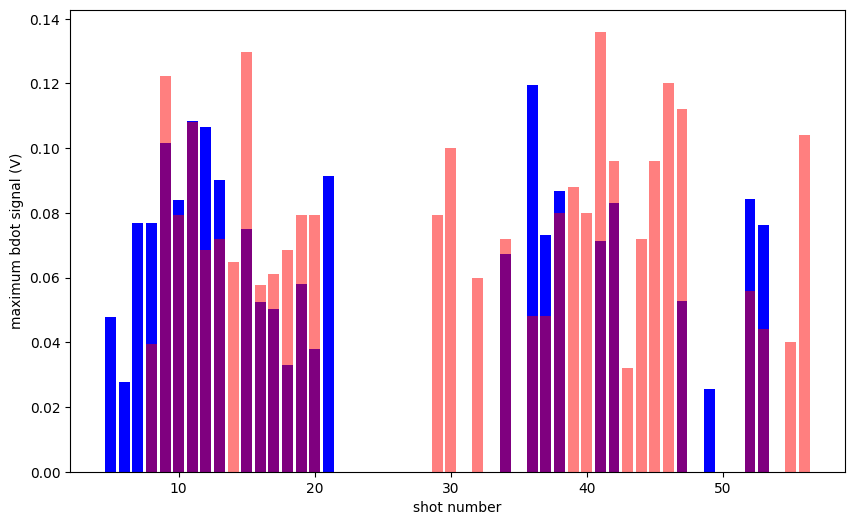

In [171]:
plt.figure(figsize= (10,6))

plt.bar(bdot_shot_no, bdot_max, color="blue")
plt.bar(pyro_shot_no, pyro_max, color="red", alpha=0.5)

plt.xlabel("shot number")
plt.ylabel("maximum bdot signal (V)")

plt.show()


In [172]:
data = read_data(shot= 34)

data

Found 2 files:
   190124FOILSHOT34000_Ch2.csv
   s34_ALL.csv


{'time': array([-1.19989375e-07, -1.19969375e-07, -1.19949375e-07, ...,
         8.79950625e-07,  8.79970625e-07,  8.79990625e-07]),
 'bdot': array([-0.00121875, -0.00196875, -0.0025625 , ...,  0.00434375,
         0.0035625 ,  0.00214844]),
 'tof': array([ 0.02359375,  0.021875  ,  0.01492187, ...,  0.00125   ,
        -0.0053125 , -0.01210938]),
 'diode': array([-4.062500e-04, -4.046875e-04, -3.953125e-04, ...,  1.406250e-05,
         7.812500e-06, -1.406250e-05]),
 'pyro_time': array([-0.05    , -0.049995, -0.04999 , ...,  0.049985,  0.04999 ,
         0.049995]),
 'Ch2': array([0.04 , 0.032, 0.048, ..., 0.008, 0.024, 0.024])}

Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv
Found 3 files:
   190124FOILSHOT8_001_Ch1.csv
   190124FOILSHOT8_001_Ch2.csv
   s08_ALL.csv


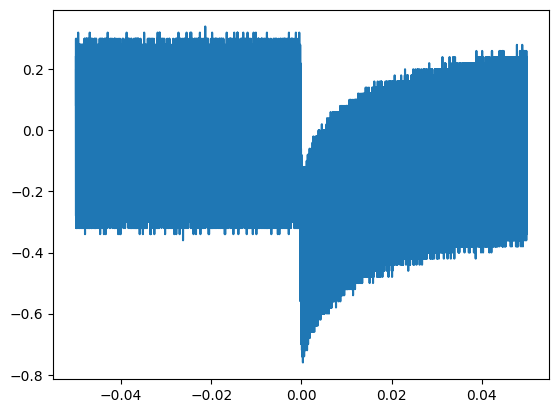

In [173]:
array_time = read_data(8)["pyro_time"]
array_data = read_data(8)["Ch1"]
plt.plot(array_time, array_data)
plt.show()